# Exploratory data analysis on London Data

This notebook will serve for exploring the London Dataset and gainging insight on how to process it 

First, we recuperate the necessary packages 

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

The data is divided in 163 datasets of 1 million entries.

We upload the data from several csv file and merge them together

In [7]:
df = pd.read_csv("Data/Londondata/Power-Networks-LCL-June2015(withAcornGps)v2_1.csv")


Add as many datasets as needed

In [11]:
for i in range(1,3): 
    dataframe = pd.read_csv(r"./Data/Londondata/Power-Networks-LCL-June2015(withAcornGps)v2_"+str(i)+".csv")
    df = df.append(dataframe)

In [12]:
df.head()

,LCLid,stdorToU,DateTime,KWH/hh (per half hour),Acorn,Acorn_grouped
0,MAC000002,Std,2012-10-12 00:30:00.0000000,0,ACORN-A,Affluent
1,MAC000002,Std,2012-10-12 01:00:00.0000000,0,ACORN-A,Affluent
2,MAC000002,Std,2012-10-12 01:30:00.0000000,0,ACORN-A,Affluent
3,MAC000002,Std,2012-10-12 02:00:00.0000000,0,ACORN-A,Affluent
4,MAC000002,Std,2012-10-12 02:30:00.0000000,0,ACORN-A,Affluent


The data ranges from 2012 to 2014, we will keep the data from 2013

In [13]:
#Get the year of observation
df["year"] = pd.to_datetime(df["DateTime"]).dt.year
df.index = df.index - 3840


#Isolate the year 2013
df = df[df["year"] == 2013]

Mak the usage be floats rather than strings

In [14]:
#Get rid of Null values
df["KWH/hh (per half hour) "] = df["KWH/hh (per half hour) "].replace('Null',np.nan)

#Get values as float
df["KWH/hh (per half hour) "] = pd.to_numeric(df["KWH/hh (per half hour) "], downcast="float")


Lets look at how many data points there is for each households (LCLid) for the 2013 year

In [15]:
df.groupby("LCLid")['KWH/hh (per half hour) '].apply(lambda x: len(x))

LCLid
MAC000002    35064
MAC000003    35060
MAC000004    35062
MAC000006    35064
MAC000007    35058
MAC000008    29010
MAC000009    35046
MAC000010    35064
MAC000011    35062
MAC000012    35062
MAC000013    35062
MAC000016     1442
MAC000018    35064
MAC000019    35064
MAC000020    35060
MAC000021    35062
MAC000022    35062
MAC000023    35062
MAC000024    35062
MAC000025    35052
MAC000026    35038
MAC000027    35064
MAC000028    26802
MAC000029    35040
MAC000030    35046
MAC000032    35062
MAC000033    35062
MAC000034    35056
MAC000035    35060
MAC000036    17531
MAC000037    17531
MAC000038    17529
MAC000039    17523
MAC000040    17532
MAC000041    17530
MAC000042    17525
MAC000043    17530
MAC000045    17531
MAC000047    17518
MAC000049    17532
MAC000050     5092
MAC000053    17528
MAC000054    17531
MAC000055    17529
MAC000056    17530
MAC000057    17532
MAC000058    17530
MAC000059    17530
MAC000060    17532
MAC000061    17531
MAC000062    17529
MAC000063    12775
MAC000

We can see that most Households have around 17530 entries, which makes sens as there are 17520 half hours in a year

Some are however far from this value. As we have plenty of data, lets delete all Household with less than 17520 data points


In [16]:
groups = df.groupby("LCLid")['KWH/hh (per half hour) '].apply(lambda x: len(x))
groups = groups[groups>17520]

ind = groups.index

df = df[df["LCLid"].isin(ind)]

Lets now study the distribution for each household, to see how it differs from one to another 

<ipython-input-17-bf5d7817f14d>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-17-bf5d7817f14d>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-17-bf5d7817f14d>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-17-bf5d7817f14d>:5: RuntimeW

<ipython-input-17-bf5d7817f14d>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


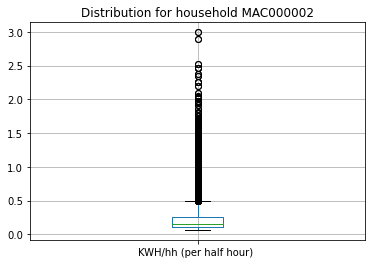

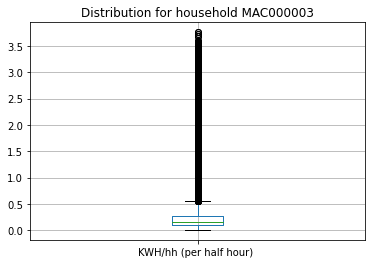

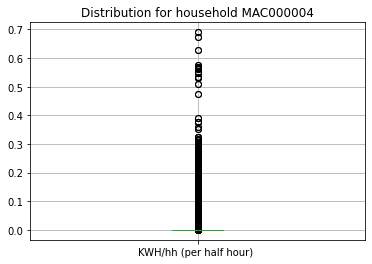

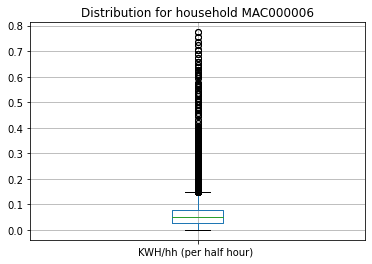

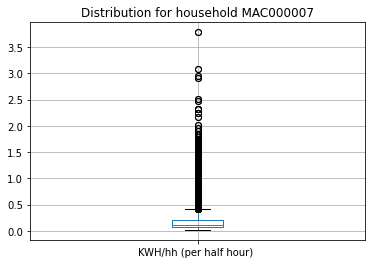

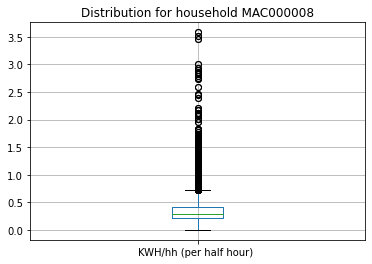

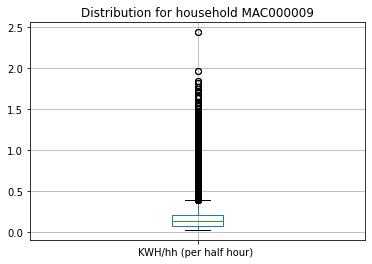

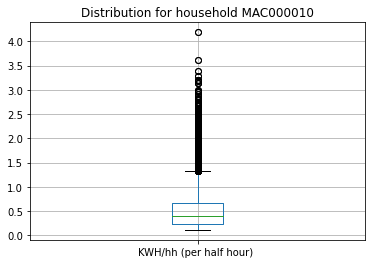

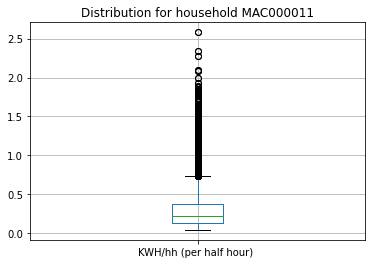

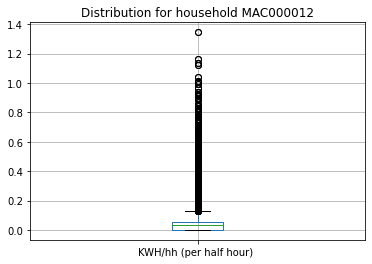

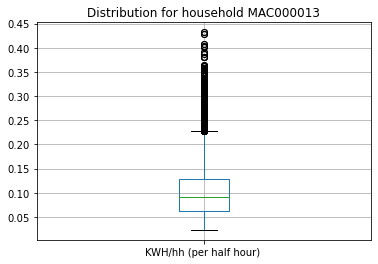

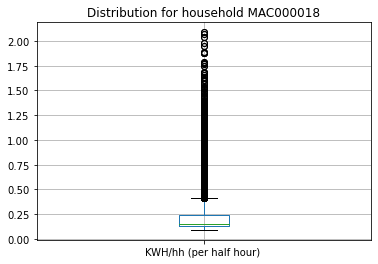

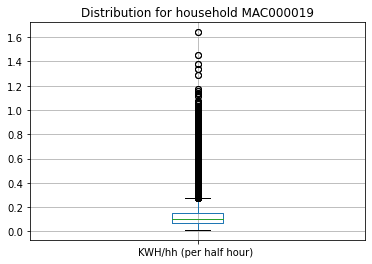

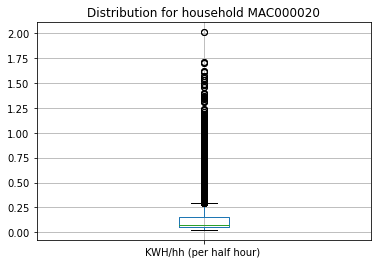

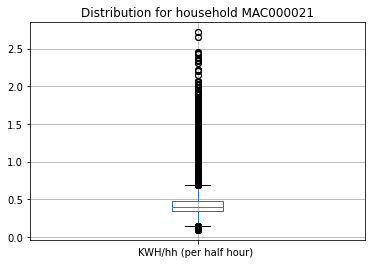

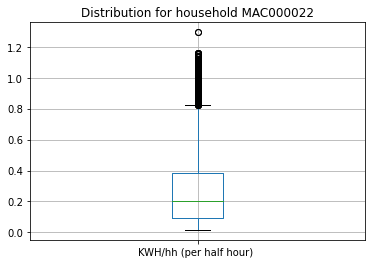

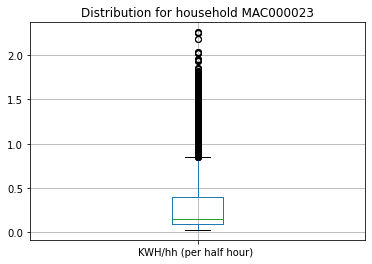

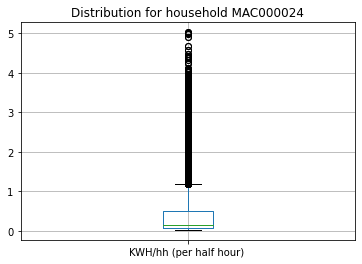

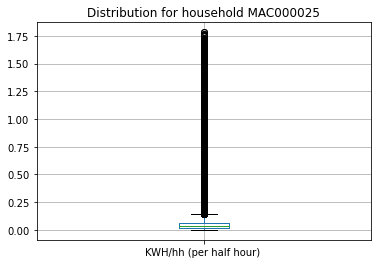

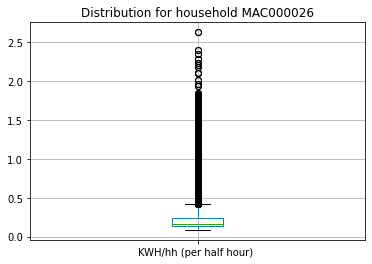

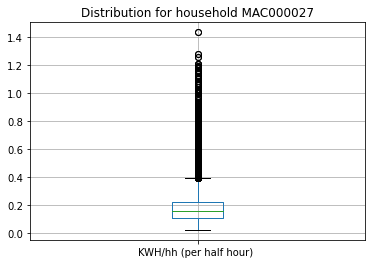

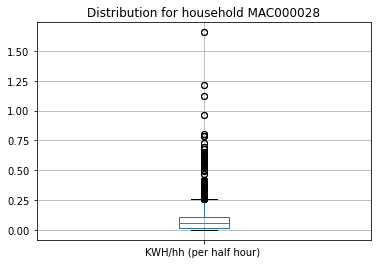

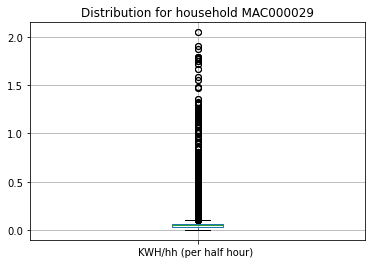

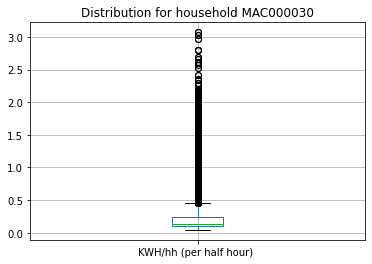

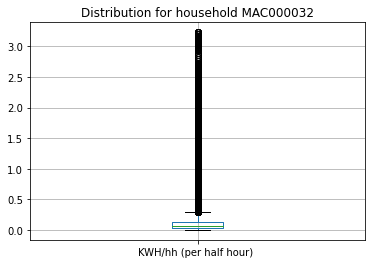

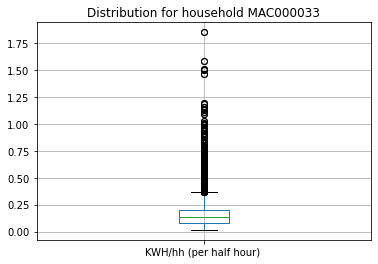

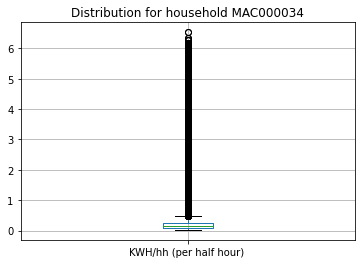

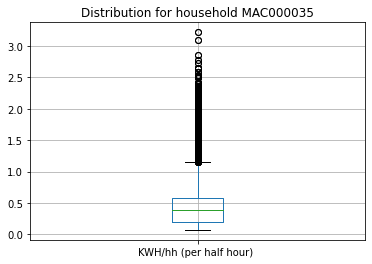

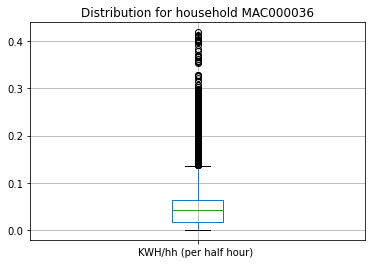

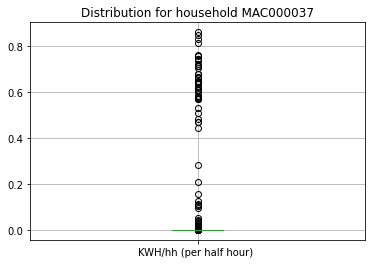

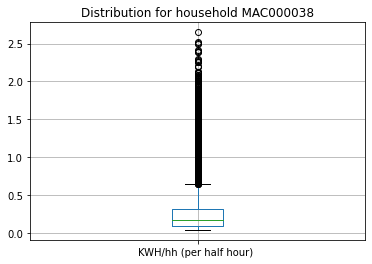

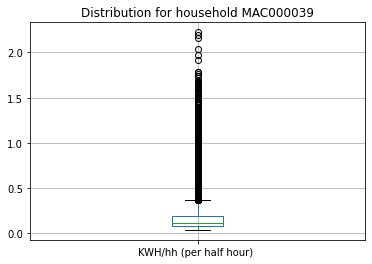

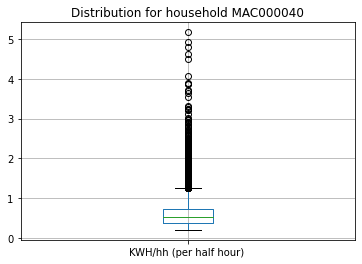

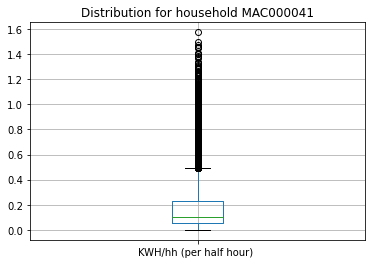

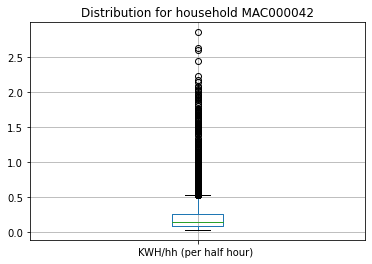

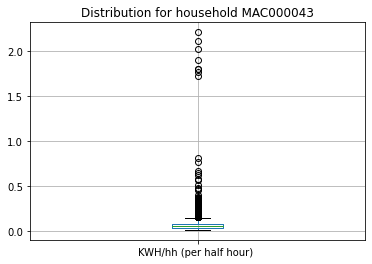

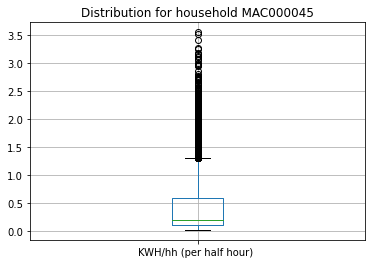

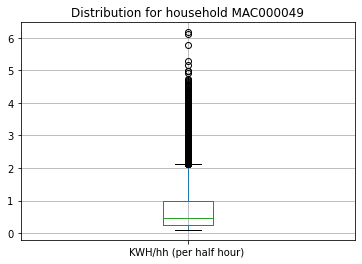

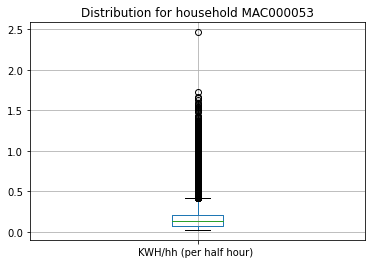

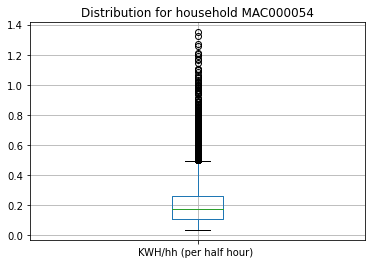

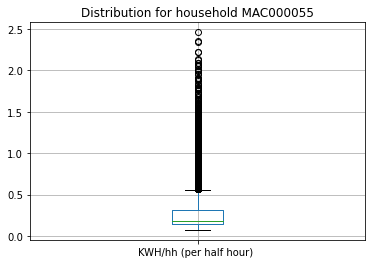

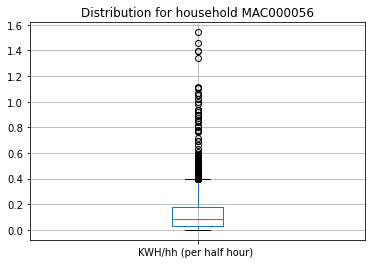

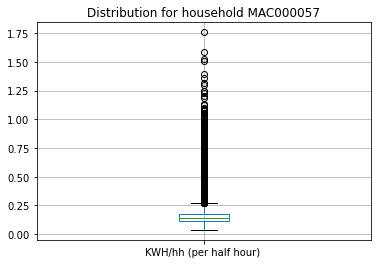

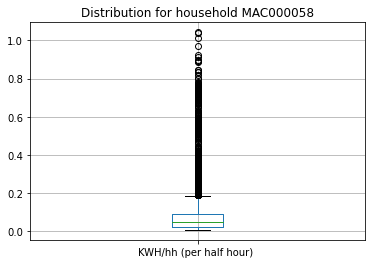

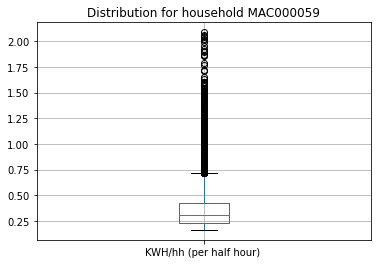

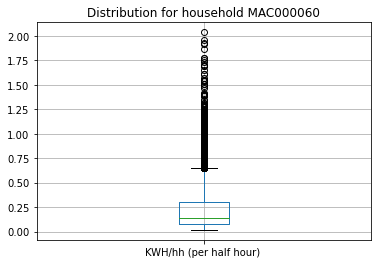

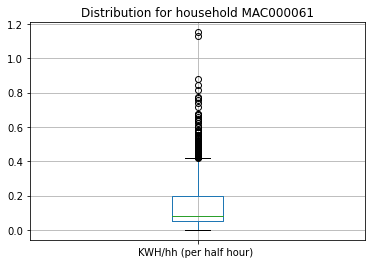

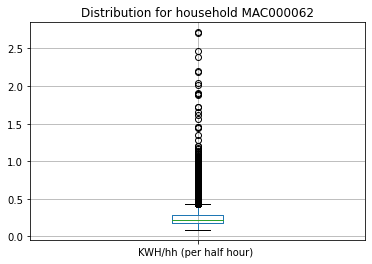

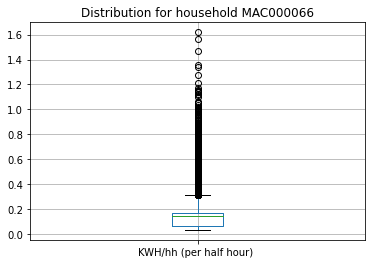

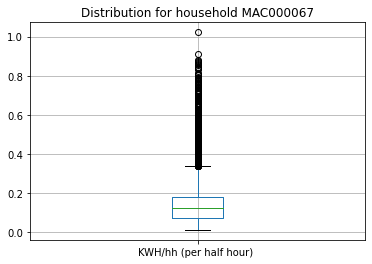

In [17]:
plots = df.groupby("LCLid")

keys = plots.groups.keys() 
for i in keys: 
    plt.figure()
    dat = plots.get_group(i)
    dat.boxplot(column = 'KWH/hh (per half hour) ')
    plt.title("Distribution for household "+ i)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 50 Text major ticklabel objects>)

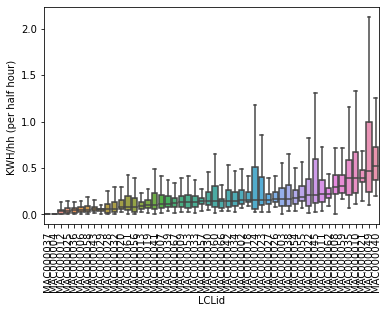

In [49]:
import seaborn as sns
fig, ax = plt.subplots()
order = df.groupby(by="LCLid").median().sort_values(by="KWH/hh (per half hour) ", ascending=True).index
g = sns.boxplot(x="LCLid", y="KWH/hh (per half hour) ", data=df, showfliers=False, order=order)

plt.xticks(rotation=90)